In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import joblib

In [2]:
def drop_columns(df):
    """
    Drops the specified columns from the DataFrame and returns the resulting DataFrame.
    Also prints the first few rows of the resulting DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    pd.DataFrame: The DataFrame after dropping the specified columns.
    """
    columns_to_drop = ['espessura', 'Index','Cluster','cluster']
    df = df.drop(columns=columns_to_drop, inplace=True)
    return df

In [3]:
# Step 1: Load the Excel file
file_path = 'df1.xlsx'
data = pd.read_excel(file_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Index               0 non-null      float64
 1   peso                473 non-null    float64
 2   comprimento_Total   473 non-null    float64
 3   comprimento_Padrao  473 non-null    float64
 4   comprimento_Cabeça  473 non-null    float64
 5   altura              473 non-null    float64
 6   espessura           473 non-null    float64
 7   Cluster             473 non-null    int64  
 8   cluster             473 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 33.4 KB


In [4]:
drop_columns(data)
data.describe()


,peso,comprimento_Total,comprimento_Padrao,comprimento_Cabeça,altura
count,473.000000,473.000000,473.000000,473.000000,473.000000
mean,528.376660,28.722600,24.175687,7.678647,8.960677
std,218.778325,4.129641,3.508781,1.197061,1.374086
min,227.250000,22.700000,16.700000,5.300000,6.500000
25%,341.280000,25.000000,20.800000,6.600000,7.900000
50%,471.500000,28.200000,24.000000,7.800000,8.800000
75%,704.860000,32.000000,27.000000,8.700000,10.000000
max,1192.000000,38.000000,31.500000,10.100000,13.000000


In [5]:

# Step 2: Define features (X) and target (y)
# Assuming the target column is named 'peso' (replace if needed)
X = data.drop(columns=['peso'])
y = data['peso']

# Handle missing values in features
imputer = SimpleImputer(strategy='mean')  # Impute with the mean of each column
X = imputer.fit_transform(X)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Step 4: Set up a grid of hyperparameters to search over for Extra Trees Regressor
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [None, 10, 20, 30],       # Maximum depth of trees
    'min_samples_split': [2, 5, 10],       # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider for splits
}

# Step 5: Define scoring metrics
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'r2': make_scorer(r2_score)
}

# Step 6: Initialize Extra Trees Regressor and GridSearchCV
extra_trees_regressor = ExtraTreesRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=extra_trees_regressor,
    param_grid=param_grid,
    scoring=scoring,
    refit='r2',  # This will select the best model based on R2 score
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)

# Step 7: Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Step 8: Get the best parameters and the best score
best_params = grid_search.best_params_
best_r2_score = grid_search.best_score_

# Step 9: Test the model on the test data and calculate final performance
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Cross-Validation R2 Score:", best_r2_score)
print("Test Mean Squared Error:", test_mse)
print("Test R2 Score:", test_r2)

C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
373 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation R2 Score: 0.9558016324003378
Test Mean Squared Error: 1161.3519523477582
Test R2 Score: 0.9765121110827838


In [6]:
# Step 8: Plot learning curves
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

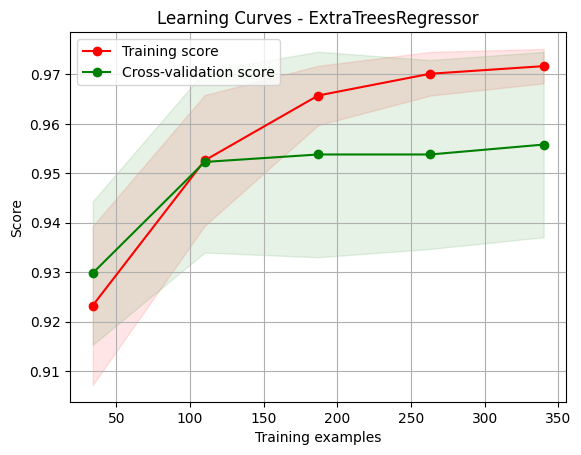

In [7]:
plot_learning_curve(best_model, "Learning Curves - ExtraTreesRegressor", X_train, y_train, cv=5, n_jobs=-1)
plt.show()

In [8]:
# Save the best model using joblib
model_filename = 'ExtraTreesRegressor_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

Model saved as ExtraTreesRegressor_model.pkl


In [9]:
# Step 10: Load the model
loaded_model = joblib.load(model_filename)
print("\nModel loaded:{model_filename}")


Model loaded:{model_filename}


In [10]:
## Vizualiasing some some predictions
print("\nSample Predictions:")
for i in range(10):
    print(f"Actual: {y_test.iloc[i]}, Predicted: {y_pred[i]}")


Sample Predictions:
Actual: 408.44, Predicted: 361.94535556541547
Actual: 335.11, Predicted: 318.69260371546295
Actual: 395.28, Predicted: 401.38064177096123
Actual: 913.28, Predicted: 974.6512575619474
Actual: 442.04, Predicted: 463.43733328658163
Actual: 658.1, Predicted: 648.8850466771293
Actual: 455.5, Predicted: 456.2669858388607
Actual: 309.72, Predicted: 323.4796299269673
Actual: 290.22, Predicted: 296.4590803355403
Actual: 316.02, Predicted: 368.14809944089126
